In [1]:
import json
import os

import chromadb
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction, SentenceTransformerEmbeddingFunction
from dotenv import load_dotenv
import tiktoken
import torch

#from src.SentenceTransformerEmbeddingFunction import SentenceTransformerEmbeddingFunction

load_dotenv()

True

## Prepare data embeddings
### Step 1 : Initialize a chromaDB

In [19]:
model_name = "dangvantuan/sentence-camembert-base"
#model_name = "text-embedding-ada-002"
# model_name = "sentence-transformers/all-MiniLM-L6-v2"

match model_name:
    case "text-embedding-ada-002":
        OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
        emb_func = OpenAIEmbeddingFunction(
                        api_key=OPENAI_API_KEY,
                        model_name="text-embedding-ada-002"
                    )

    case other:
        emb_func = SentenceTransformerEmbeddingFunction(
            model_name=model_name,
            device="cuda" if torch.cuda.is_available() else "cpu")


chroma_client = chromadb.PersistentClient(path=os.path.join("./ChromaDB", model_name))

### Step 2 : Add chunked documents to chroma

In [47]:
# create collection using folder's name
SOURCE_FOLDER = "../data\D26\ladrome-2023-12-22-page-chunked-v1"

collection = chroma_client.get_or_create_collection(
    os.path.basename(SOURCE_FOLDER),
    metadata={"hnsw:space": "cosine"},
    embedding_function=emb_func)

In [48]:
# if needed delete a collection
# chroma_client.delete_collection(os.path.basename(SOURCE_FOLDER))

In [49]:
# read the files
file_list = os.listdir(SOURCE_FOLDER)

def read_file(file):
    with open(os.path.join(SOURCE_FOLDER, file), "r") as f:
        return json.load(f)

data = [read_file(f) | {"file": f} for f in file_list]
data[0]

{'id': 'ladrome-page-10511-0.json',
 'token_count': 657,
 'word_count': 361,
 'source_file': 'ladrome-page-10511.json',
 'text': '# Un peu d’histoire\nSituée à mi-chemin entre l’Europe du nord et du sud, à la croisée des vallées du Rhône et de l’Isère, le département de la Drôme a toujours été une terre de passage, de brassage culturel et économique. La rivière Drôme, qui la transperce d’est en ouest, lui a donné son nom. Ses limites administratives ont été fixées en 1790 et en ont fait un département trait d’union entre Dauphiné et Provence. Rivière La Drôme – Crest © Francis Rey Terre d’asile pour les convertis à la Réforme, puis pour les Arméniens survivants du génocide de 1915, la Drôme s’engagea avec bravoure dans la Résistance contre l’occupant nazi. Le massif du Vercors garde la trace du martyre des maquisards et de la population civile perpétré lors des massacres de juillet 1944. La dernière moitié du 20esiècle a vu la Drôme développer ses infrastructures (autoroutes, gare TGV,

In [50]:
# Get an estimate of the total number of token (for cost estimation)
tokeniser = tiktoken.get_encoding("cl100k_base")

n_tokens = sum([len(tokeniser.encode(d["text"])) for d in data])
print("Amount of tokens :", n_tokens)
cost = round(n_tokens/1000*0.0001, 2)
print("Cost using ADAv2 : ", cost, "$")
if cost > 1:
    print("WARNING, BEWARE OF THE COST")

Amount of tokens : 115489
Cost using ADAv2 :  0.01 $


In [51]:
# Build lists to add to chroma
def truncate_text(text, max_tokens_length=8192):
    encoded_text = tokeniser.encode(text)
    return tokeniser.decode(encoded_text[:max_tokens_length])

documents = [truncate_text(d["text"]) for d in data]
metadatas = [{k:v for k,v in d.items() if k in ["chunk_id", "source_file"]} for d in data]
ids = [d["file"] for d in data]

collection.add(
    documents=documents,
    metadatas=metadatas,
    ids=ids,
)

### Step 3 : add old version of chunks in another collection

In [91]:
# create collection using folder's name
SOURCE_FOLDER = "../data\D26\ladrome-2023-12-22-md"

collection = chroma_client.get_or_create_collection(
    os.path.basename(SOURCE_FOLDER),
    metadata={"hnsw:space": "cosine"},
    embedding_function=emb_func)


In [92]:
# Delete collection if needed
# chroma_client.delete_collection(os.path.basename(SOURCE_FOLDER))

In [93]:
# read the files
file_list = os.listdir(SOURCE_FOLDER)

def read_file(file):
    with open(os.path.join(SOURCE_FOLDER, file), "r") as f:
        return json.load(f)

data = [read_file(f) | {"file": f} for f in file_list]
data[0]

{'@context': 'https://wikit.ai',
 '@type': 'Document',
 'identifier': 'ladrome:page:10511',
 'name': 'un-peu-dhistoire',
 'title': 'Un peu d’histoire',
 'source': 'La Drôme.fr',
 'url': 'https://www.ladrome.fr/mon-departement/la-drome/un-peu-dhistoire/',
 'dateCreated': '2019-01-07T16:11:49',
 'dateModified': '2023-09-20T10:49:08',
 'fileFormat': 'text/markdown',
 'hasPart': [{'@type': 'DocumentChunk',
   'title': 'Un peu d’histoire',
   'text': 'Un peu d’histoire\n\nSituée à mi-chemin entre l’Europe du nord et du sud, à la croisée des vallées du Rhône et de l’Isère, le département de la Drôme a toujours été une terre de passage, de brassage culturel et économique.\n\nLa rivière Drôme, qui la transperce d’est en ouest, lui a donné son nom. Ses limites administratives ont été fixées en 1790 et en ont fait un département trait d’union entre Dauphiné et Provence.\n\n[![](https://www.ladrome.fr/wp-content/uploads/2023/09/riviere-drome-crest-rey-003.jpg)](https://www.ladrome.fr/wp-content/u

In [94]:
# Get an estimate of the total number of token (for cost estimation)
tokeniser = tiktoken.get_encoding("cl100k_base")

n_tokens = sum([len(tokeniser.encode(d["hasPart"][0]["text"])) for d in data])
print("Amount of tokens :", n_tokens)
cost = round(n_tokens/1000*0.0001, 2)
print("Cost using ADAv2 : ", cost, "$")
if cost > 1:
    print("WARNING, BEWARE OF THE COST")

Amount of tokens : 111377
Cost using ADAv2 :  0.01 $


In [95]:
def truncate_text(text, max_tokens_length=8192):
    encoded_text = tokeniser.encode(text)
    return tokeniser.decode(encoded_text[:max_tokens_length])

# Build lists to add to chroma
documents = [truncate_text(d["hasPart"][0]["text"]) for d in data]
metadatas = [{"source_file":d["file"]} for d in data]
ids = [d["file"] for d in data]

collection.add(
    documents=documents,
    metadatas=metadatas,
    ids=ids,
)

## Try out the DB

In [64]:
# Choose a collection name
#collection_name = "ladrome-2023-12-22-page-chunked-v1"
collection_name = "ladrome-2023-12-22-md"
# Choose a query
query = "Adresse de la MDA de Valence ?"
# choose the number of results
n_results = 10
# choose whether or not results are printed
print_results = True

collection = chroma_client.get_or_create_collection(
    collection_name,
    metadata={"hnsw:space": "cosine"},
    embedding_function=emb_func)

result = collection.query(
    query_texts=query,
    n_results=n_results,
)

if print_results:
    for rd, id in zip(result["documents"][0], result["ids"][0]):
        print(f"---------{id}---------")
        print(rd)

---------ladrome-page-10936.json---------
La lutte contre la tuberculose

Vous pensez avoir été en contact avec une personne atteinte de la tuberculose ?

En cas de suspicion de symptômes, consultez le Centre de Lutte Anti-Tuberculeux (CLAT) de la Drôme.

13 avenue Maurice Faure

BP 81132 – 26 011 Valence Cedex 9

Tel 04 75 79 70 71
---------ladrome-page-11020.json---------
Les stations de la Drôme


---------ladrome-page-10565.json---------
Un département, des territoires

Située au cœur du grand Sud-Est de la France, la Drôme est l’un des 12 départements de la Région Auvergne Rhône-Alpes.

*   **Préfecture** : Valence
*   **Sous-préfectures** : Die, Nyons
*   **Villes de plus de 10 000 habitants** : Valence, Montélimar, Romans, Bourg-lès-Valence, Pierrelatte, Bourg de Péage
*   **A savoir** : la Drôme est depuis toujours un département pionnier en agriculture bio, et le 1er département agricole d’Auvergne Rhône-Alpes
*   **Particularité** : comme son nom l’indique, l’enclave des Pape

## Test with labeled dataset
### Step 1 : read dataset

In [65]:
import pandas as pd

In [73]:
dataset = pd.read_excel("../data/D26/D26_dataset_handmade.xlsx")
dataset["relevant_chunk_ids"] = dataset["relevant_chunk_ids"].str.split()
dataset.dropna(inplace=True, subset=["relevant_chunk_ids"])
dataset.head()

,queries,queries as keywords,chunk_version,relevant_chunk_ids,useful_links_available,long answer,keywords,Unnamed: 7
0,Combien de productions ont déjà bénéficié du f...,bénéficiare fond soutien œuvres animées,1.0,[ladrome-page-573222-1.json],NaN,15 à 20 projet bénéficient d'une subvention ch...,83,NaN
1,Je voudrais bénéficier de l'accueil familial. ...,contact acceuil familial,1.0,[ladrome-page-13929-0.json],NaN,Vous pouvez contacter Drôme Solidarités\n04 75...,Drôme Solidarités 04 75 79 70 09 dromeseniorso...,NaN
2,Quels sont les horaires du musée départemental...,horaire musée de la résistance,1.0,[ladrome-page-10958-3.json],NaN,Les horaires d'ouverture varient d'un mois à l...,"avril :du mardi au dimanche, de 10h à 12h et d...",NaN
3,Quels sont les résultats de conformité du site...,résultats conformité acessibilité site,1.0,[ladrome-page-479533-2.json],NaN,L’audit de conformité au RGAA 4.1 réalisé par ...,0.8958,NaN
4,Qu'est ce que la cartoucherie ?,explication cartoucherie,1.0,[ladrome-page-10516-3.json],NaN,Sous l’impulsion de Jacques-Rémy Girerd (studi...,pôle d’excellence régional de l’image animée,NaN


### Step 2 : Test with new chunks

In [101]:
# Choose a collection name
collection_name = "ladrome-2023-12-22-page-chunked-v1"

# Query the DB with all queries
queries = dataset["queries"].tolist()
collection = chroma_client.get_or_create_collection(
    collection_name,
    metadata={"hnsw:space": "cosine"},
    embedding_function=emb_func)
n_results = collection.count() # get the results on the entire DB

print(f"The collection has {collection.count()} documents")

result = collection.query(
    query_texts=queries,
    n_results=n_results,
)

The collection has 361 documents


In [102]:
result_df = pd.DataFrame.from_dict(result)
result_df.drop(["embeddings", "uris", "data"], inplace=True, axis=1)
result_df["query"] = queries
result_df["label"] = dataset["relevant_chunk_ids"].tolist()
result_df.head(3)

,ids,distances,metadatas,documents,query,label
0,"[ladrome-page-573222-1.json, ladrome-page-1096...","[0.575617840095566, 0.6614375114440918, 0.7035...","[{'source_file': 'ladrome-page-573222.json'}, ...",[# Le cinéma d’animation dans la Drôme\n### Le...,Combien de productions ont déjà bénéficié du f...,[ladrome-page-573222-1.json]
1,"[ladrome-page-10759-0.json, ladrome-page-10765...","[0.49739736318588257, 0.51413893699646, 0.5231...","[{'source_file': 'ladrome-page-10759.json'}, {...","[# L’adoption\nAdopter un enfant, c’est répond...",Je voudrais bénéficier de l'accueil familial. ...,[ladrome-page-13929-0.json]
2,"[ladrome-page-10958-0.json, ladrome-page-10958...","[0.48037004470825195, 0.5899790525436401, 0.59...","[{'source_file': 'ladrome-page-10958.json'}, {...",[# Le musée départemental de la Résistance du ...,Quels sont les horaires du musée départemental...,[ladrome-page-10958-3.json]


In [103]:
# Get the position of the labeled document in the results using metadatas
# best if rank closer to 0
def get_label_position(row):
    # get the source files, which are ordered by distance
    return row["ids"].index(row["label"][0])


result_df["label_rank"] = result_df.apply(get_label_position, axis=1)
result_df = result_df.sort_values(by="label_rank").reset_index()
# show the result
result_df[["query", "label_rank", "label"]].head(100)

,query,label_rank,label
0,Combien de productions ont déjà bénéficié du f...,0,[ladrome-page-573222-1.json]
1,Où puis-je trouver les logo du département ?,0,[ladrome-page-62538-0.json]
2,Je voudrais me mettre au basket. Où puis-je tr...,0,[ladrome-page-11012-0.json]
3,Quelles sont les règles du buget participatif ?,0,[ladrome-page-547395-6.json]
4,Par quelles villes va passer la flamme olympiq...,0,[ladrome-page-567239-2.json]
...,...,...,...
74,Ou en est mon dossier AAH ?,98,[ladrome-page-10791-0.json]
75,Quels sont les tiers lieux en drome ?,189,[ladrome-page-504975-0.json]
76,C'est quoi le CDJ ? A quoi ça sert ?,194,[ladrome-page-11080-0.json]
77,J'aimerai obtenir des information sur la situa...,225,[ladrome-page-582085-4.json]


In [78]:
# analyze result of the specific query id
query_id = 49 # the index of the dataframe above
topk = 10

record = result_df.iloc[query_id]
print(record["query"])
for i, (id, r) in enumerate(zip(record["ids"][:topk], record["documents"][:topk])):
    print(f"Chunk n°{i}--------------{id}------------------")
    print(r)

Comment puis-je obtenir la carte top dép'art ?
Chunk n°0--------------ladrome-page-17218-5.json------------------
# La carte Top Dép’Art
## Pour commander la carte Top Dép’Artcarte-topdepart.ladrome.fr (pour plus d'informations : https://carte-topdepart.ladrome.fr/Accueil/)
### Où utiliser ma carte top dép’art ?
Retrouvez sur la carte interactive (pour plus d'informations : https://carte-topdepart.ladrome.fr/Beneficiaires/Views/RechercheLocalisation_PartenaireV2.aspx) la liste des partenaires qui acceptent le paiement avec la carte Top Dép’art.

Chunk n°1--------------ladrome-page-17218-0.json------------------
# La carte Top Dép’Art
Acheter un livre, payer sa licence de sport, visiter une exposition ou prendre des cours de théâtre, le Département délivre chaque année la carte « Top Dép’art », à tous les collégiens de la Drôme. ---

Chunk n°2--------------ladrome-page-17218-3.json------------------
# La carte Top Dép’Art
## Pour commander la carte Top Dép’Artcarte-topdepart.ladrome.fr 

In [104]:
# Store df in new variable for comparison later
result_new_chunks = result_df.copy()

### Step 3: Test with old chunks

In [96]:
# Choose a collection name
collection_name = "ladrome-2023-12-22-md"

# Query the DB with all queries
queries = dataset["queries"].tolist()
collection = chroma_client.get_or_create_collection(
    collection_name, metadata={"hnsw:space": "cosine"},
    embedding_function=emb_func)

n_results = collection.count() # get the results on the entire DB

print(f"The collection has {collection.count()} documents")

result = collection.query(
    query_texts=queries,
    n_results=n_results,
)

The collection has 191 documents


In [97]:
result_df = pd.DataFrame.from_dict(result)
result_df.drop(["embeddings", "uris", "data"], inplace=True, axis=1)
result_df["query"] = queries
result_df["label"] = dataset["relevant_chunk_ids"].tolist()
result_df.head(3)

,ids,distances,metadatas,documents,query,label
0,"[ladrome-page-10962.json, ladrome-page-10710.j...","[0.6844645142555237, 0.6964281797409058, 0.759...","[{'source_file': 'ladrome-page-10962.json'}, {...",[Enseignements artistiques\n\nOutils majeurs d...,Combien de productions ont déjà bénéficié du f...,[ladrome-page-573222-1.json]
1,"[ladrome-page-10759.json, ladrome-page-13929.j...","[0.49768853187561035, 0.5210072013881537, 0.55...","[{'source_file': 'ladrome-page-10759.json'}, {...","[L’adoption\n\nAdopter un enfant, c’est répond...",Je voudrais bénéficier de l'accueil familial. ...,[ladrome-page-13929-0.json]
2,"[ladrome-page-10958.json, ladrome-page-10972.j...","[0.5489376783370972, 0.7043828964233398, 0.717...","[{'source_file': 'ladrome-page-10958.json'}, {...",[Le musée départemental de la Résistance du Ve...,Quels sont les horaires du musée départemental...,[ladrome-page-10958-3.json]


In [98]:
# Get the position of the labeled document in the results using metadatas
# best if rank closer to 0
def get_label_position(row):
    label = row["label"][0].split("-")[2]
    label = "ladrome-page-" + label + ".json"
    # get the source files, which are ordered by distance
    return row["ids"].index(label)


result_df["label_rank"] = result_df.apply(get_label_position, axis=1)
result_df = result_df.sort_values(by="label_rank").reset_index()
# show the result
result_df[["query", "label_rank", "label"]].head(50)

,query,label_rank,label
0,Je voudrais installer un monte escalier mais ç...,0,[ladrome-page-10901-0.json]
1,"J'ai perdu ma carte top départ, je fais commen...",0,[ladrome-page-17218-6.json]
2,Où puis-je consulter les annonces des marchés ...,0,[ladrome-page-95161-0.json]
3,Par quelles villes va passer la flamme olympiq...,0,[ladrome-page-567239-2.json]
4,Je voudrais savoir si je suis éligible à la fi...,0,[ladrome-page-504961-0.json]
5,Où se déroulent les scéances publiques ?,0,[ladrome-page-541482-1.json]
6,Je souhaite obtenir une aide ménagère à domicile,0,[ladrome-page-10868-0.json]
7,Mon père est violent avec ma mère,0,[ladrome-page-10799-0.json]
8,Ai-je le droit de proposer une idée pour le bu...,0,[ladrome-page-547395-2.json]
9,Nous voudrions faire une ballade en forêt,0,[ladrome-page-61260-0.json]


In [76]:
# analyze result of the specific query id
query_id = 35 # the index of the dataframe above
topk = 10

record = result_df.iloc[query_id]
print(record["query"])
for i, r in zip(record["ids"][:topk], record["documents"][:topk]):
    print(f"----------------{i}------------------")
    print(r)

J'aimerai avec des infos sur le sentier du karst
----------------11020------------------
Les stations de la Drôme


----------------61497------------------
Alpage de Font d’Urle (Vercors)

Grandiose, spectaculaire, sauvage…  
Tels sont les mots qui viennent à l’esprit en évoquant l’alpage de Font d’Urle, ce plateau de 618 hectares propriété du Département de la Drôme depuis 1953.

C’est **un site géologique** passionnant, où se rencontrent des formes spectaculaires liées à l’érosion du calcaire par l’eau, appelées « karst » : roche sculptée en surface, crevasses, puits naturels, grottes, rivières souterraines…

[![](https://www.ladrome.fr/wp-content/uploads/2020/02/ecogarde-matras-004.jpg)](https://www.ladrome.fr/wp-content/uploads/2020/02/ecogarde-matras-004.jpg)

[![](https://www.ladrome.fr/wp-content/uploads/2020/02/font-durle-matras-006.jpg)](https://www.ladrome.fr/wp-content/uploads/2020/02/font-durle-matras-006.jpg)

[![](https://www.ladrome.fr/wp-content/uploads/2020/02/font-dur

In [99]:
# Store result in new variable for comparison later
result_old_chunks = result_df.copy()

### Step 4 : Compare !
#### Position of the relevant document in the retrieved documents

In [105]:
new_collection_size = len(result_new_chunks.iloc[0]["ids"])
print(f"Collection size : {new_collection_size}")
result_new_chunks.head(2)

Collection size : 361


,index,ids,distances,metadatas,documents,query,label,label_rank
0,0,"[ladrome-page-573222-1.json, ladrome-page-1096...","[0.575617840095566, 0.6614375114440918, 0.7035...","[{'source_file': 'ladrome-page-573222.json'}, ...",[# Le cinéma d’animation dans la Drôme\n### Le...,Combien de productions ont déjà bénéficié du f...,[ladrome-page-573222-1.json],0
1,29,"[ladrome-page-62538-0.json, ladrome-page-10728...","[0.6856098959777752, 0.6959853768348694, 0.726...","[{'source_file': 'ladrome-page-62538.json'}, {...",[# Charte graphique\nLe logo du Département de...,Où puis-je trouver les logo du département ?,[ladrome-page-62538-0.json],0


In [106]:
old_collection_size = len(result_old_chunks.iloc[0]["ids"])
print(f"Collection size : {old_collection_size}")
result_old_chunks.head(2)

Collection size : 191


,index,ids,distances,metadatas,documents,query,label,label_rank
0,39,"[ladrome-page-10901.json, ladrome-page-10870.j...","[0.7409710884094238, 0.7820833921432495, 0.828...","[{'source_file': 'ladrome-page-10901.json'}, {...",[Logement adapté\n\nUn logement inadapté peut ...,Je voudrais installer un monte escalier mais ç...,[ladrome-page-10901-0.json],0
1,59,"[ladrome-page-17218.json, ladrome-page-10728.j...","[0.7730540462319198, 0.7842181324958801, 0.786...","[{'source_file': 'ladrome-page-17218.json'}, {...","[La carte Top Dép’Art\n\n**Acheter un livre, p...","J'ai perdu ma carte top départ, je fais commen...",[ladrome-page-17218-6.json],0


In [107]:
def get_label_rank_percentage(result_df, collection_size):
    """Get the cumulative percentage of the rank of the relevant document

    Args:
        result_df (pd.DataFrame): the results of the retriever
        collection_size (int): the size of the collection of documents
    """
    chunk_rank_counts = result_df["label_rank"].value_counts().sort_index()
    missing_indexes = [i for i in range(collection_size) if i not in chunk_rank_counts.index]
    chunk_rank_counts = pd.concat(
        [chunk_rank_counts,
        pd.DataFrame([0 for _ in range(len(missing_indexes))],
        index=missing_indexes)]).sort_index()
    chunk_rank_percent = chunk_rank_counts.cumsum().div(len(result_df)).round(3)

    return chunk_rank_percent

In [108]:
new_chunk_rank_percent = get_label_rank_percentage(result_new_chunks, new_collection_size).rename(columns={0: "New chunks"})
old_chunk_rank_percent = get_label_rank_percentage(result_old_chunks, old_collection_size).rename(columns={0: "Old chunks"})

<Axes: >

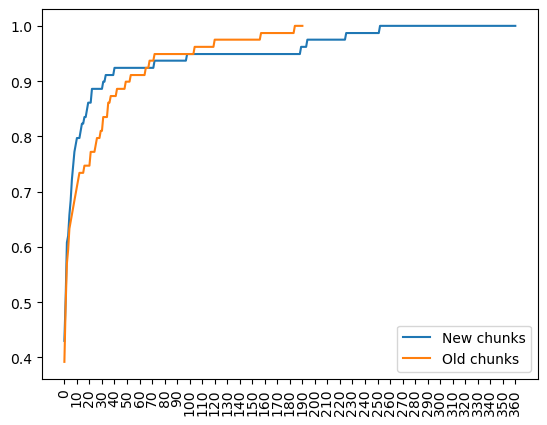

In [109]:
# Plot the cumulative percentage of retrieval position
df_to_plot = pd.concat([new_chunk_rank_percent, old_chunk_rank_percent], axis=1)
df_to_plot.plot(xticks=[i for i in df_to_plot.index if i % 10 == 0], rot=90)

As we can see, the new chunking method performs better : the position at which the relevant document is retrieved is closer to 0, despite having a greater amount of documents in the collection !
WARNING : As the queries were built using the new chunks, there might be bias to keep in mind !

<Axes: >

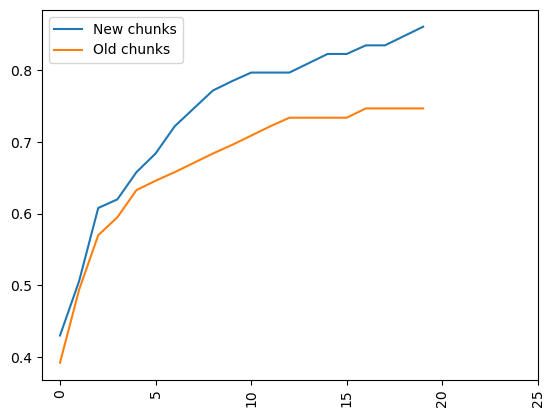

In [110]:
# Zoom on the begining of the curve
df_to_plot[:20].plot(xticks=[i for i in df_to_plot.index[:30] if i % 5 == 0], rot=90)

If we zoom in, we actually see that the old chunks perform better in terms of top 1 : in 50% of case, the relevant document is retrieved at index 0. Howerver, the new chunks perfrom better if we llok at top 5 or top 10.

#### Length of the context depending on amount of chunks selected

In [111]:
import tiktoken

def get_topks_relevance(result_df, topks=[1,5,10,20]):

    def get_context_length(docs, n_docs):
        return sum([len(tokenizer.encode(doc)) for doc in docs[:n_docs]])

    tokenizer = tiktoken.get_encoding("cl100k_base")
    records = {}
    for topk in topks:
        relevant_is_here = round(len(result_df[result_df["label_rank"] < topk]) / len(result_df) * 100, 1)
        mean_length_of_context = result_df["documents"].apply(get_context_length, args=[topk]).mean().round()
        median_length_of_context = result_df["documents"].apply(get_context_length, args=[topk]).median().round()

        records[topk] = {"relevant_isin_ctx%":relevant_is_here, "mean_token_count_in_ctx": mean_length_of_context, "median_token_count_in_ctx":median_length_of_context}

    return pd.DataFrame.from_records(records)

In [112]:
print("Values of context length for topk for NEW chunks")
get_topks_relevance(result_new_chunks)

Values of context length for topk for NEW chunks


,1,5,10,20
relevant_isin_ctx%,43.0,65.8,78.5,86.1
mean_token_count_in_ctx,374.0,1784.0,3733.0,7224.0
median_token_count_in_ctx,187.0,1492.0,3344.0,6665.0


In [113]:
print("Values of context length for topk for OLD chunks")
get_topks_relevance(result_old_chunks, topks=[1, 5, 10, 20])

Values of context length for topk for OLD chunks


,1,5,10,20
relevant_isin_ctx%,39.2,63.3,69.6,74.7
mean_token_count_in_ctx,617.0,2687.0,5333.0,10771.0
median_token_count_in_ctx,472.0,2331.0,4934.0,10185.0


##### Interpretation
- Relevant_is_ctx% = How many times the relevant document is in the context, if we keep only the top k documents (as a percentage among the queries of the dataset). -> by increasing the amount of documents we keep, we increase the amount the frequency at which the relevant document is in the context

- mean_token_count_in_ctx = The average amount tokens in the context. As we increase the k amount of documents we keep, the length of the context increases. This is not what we want, as higher context length means more superfluous information for the LLM, and more money spent for querying the LLM !

- median_token_count_in_ctx = same as above, but median instead of mean


##### Conclusion
It seems that the new chunking method present several advantages over the old method:
- It has better retrieval rates
- it allows for smaller chunks, resulting in smaller context : on average the token amount in the context is divided by 2. Thus we can hope an increase in performance in terms of response generation by the LLM
- the retrieval performance of the new chunking method is better, even though the amount of documents is multiplied by 2

##### Disclaimer
- Keep in mind that the queries of the test dataset where formulated by using the new chunks. Thus the dataset may be biased toward the new chunks method
- Some problems needs to be solved : for example with the new chunking method, the text of a part that is outside its subpart is discarded (e.g. the introductions of part) resulting in a loss of information